In [ ]:
#to be run only when on Google Colab
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

In [1]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
!pip install tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
    """
      Load the data to a pandas dataframe.
      Dataframe Columns:
      title
      para_index
      context
      q_index
      q_id
      q_isimpossible
      q_question
      q_anscount - number of answers
      q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
    """
    result = []
    for pdata in data['data']:
        for para in pdata['paragraphs']:
            for q in para['qas']:
                result.append({
                                'title' : pdata['title'],
                                'context' : para['context'],
                                'q_id' : q['id'],
                                'q_isimpossible' : q['is_impossible'],
                                'q_question' : q['question'],
                                'q_anscount' : len(q['answers']),
                                'q_answers' : [a for a in q['answers']],
                                'q_answers_text': [a.get("text") for a in q['answers']],
                                'context_lowercase': para['context'].lower(),
                                'q_question_lowercase' : q['question'].lower(),
                                'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']]
                               })
    return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
    """
    Download a file from google drive with the shared link
    """ 
    data = load_json_file(filename)
    return convert_to_pd(data)

In [2]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [6]:
context_maxlen = 250
question_maxlen = 20
answer_maxlen = 15
ndim = 100

In [7]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def calc_answer_span(context,answer):
    
    ans_len = len(answer)
    
    if ans_len!=0 and answer[0] in context:
        indices = [i for i, x in enumerate(context) if x == answer[0]]
        try:
            if(len(indices)>1):
                start = [i for i in indices if (context[i:i+ans_len] == answer) ]
                end = start[0] + ans_len - 1
                return (start[0],end)
            else:
                start = context.index(answer[0])
                end = start + ans_len - 1
                return (start,end)
        except:
            return (-1,-1)
    else:
        return (-1,-1)


def vectorize_data(tokenizer_obj,train_lists):
    qid_original = train_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_span = [calc_answer_span(context_seq[i],answer_seq[i]) for i,x in enumerate(context_seq)]
    answer_start_index = [item[0] for item in answer_span]
    answer_end_index =  [item[1] for item in answer_span]
    answer_start_seq = []
    answer_end_seq = []
    for i,x in enumerate(answer_start_index):
        start = np.zeros(context_maxlen,dtype = "int32")
        end   = np.zeros(context_maxlen,dtype = "int32")
        #last space reserved for the question where there are no answers
        if (answer_start_index[i] < context_maxlen-1):
            start[answer_start_index[i]] = 1
        if (answer_end_index[i] < context_maxlen-1):
            end[answer_end_index[i]] = 1
        answer_start_seq.append(start)
        answer_end_seq.append(end)
        
    answer_input_seq = [i for i in answer_seq]
    answer_target_seq = answer_input_seq
    context_seq_padded = pad_sequences(context_seq,context_maxlen-1,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    answer_start_seq_padded = pad_sequences(answer_start_seq,context_maxlen,padding='post', truncating='post') 
    answer_end_seq_padded = pad_sequences(answer_end_seq,context_maxlen,padding='post', truncating='post')
    #context_match_question = []
    #for i,a in enumerate(context_seq_padded):
    #    exact = [[1]if ecw in question_seq_padded[i] and ecw !=0 else [0] for ecw in a]
    #    context_match_question.append(exact)
    
    #context_match_question_padded = np.array(context_match_question)
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    qid = [qid_original[i] for i in indices]
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible = answer_impossible[indices]
    answer_start_seq_padded = answer_start_seq_padded[indices]
    answer_end_seq_padded = answer_end_seq_padded[indices]
    #context_match_question_padded = context_match_question_padded[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_qid = qid[:train_samples]
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible[:train_samples]
    train_answer_start_seq_padded = answer_start_seq_padded[:train_samples]
    train_answer_end_seq_padded = answer_end_seq_padded[:train_samples]
    #train_context_match_question_padded = context_match_question_padded[:train_samples]
    val_qid = qid[train_samples:end_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible[train_samples:end_samples]
    val_answer_start_seq_padded = answer_start_seq_padded[train_samples:end_samples]
    val_answer_end_seq_padded = answer_end_seq_padded[train_samples:end_samples]
    #val_context_match_question_padded = context_match_question_padded[train_samples:end_samples]
    return (train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            train_answer_start_seq_padded,train_answer_end_seq_padded,
            #train_context_match_question_padded,
            val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,
            val_answer_start_seq_padded,val_answer_end_seq_padded
            #,val_context_match_question_padded
           )

train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,\
train_answer_start_seq_padded,train_answer_end_seq_padded,\
val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,\
val_answer_start_seq_padded,val_answer_end_seq_padded\
= vectorize_data(tokenizer_obj,train_lists)
print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [8]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [9]:
embedding_matrix.shape

(88702, 100)

In [10]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.WSTART = tf.keras.layers.Dense(2*self.num_unit_gru)
        self.WEND = tf.keras.layers.Dense(2*self.num_unit_gru)        
    
    def call(self,
             question,
             context):
        
        context = tf.transpose(context,[0,2,1])
        ################ start prediction logit ######################
        start = self.WSTART(question)
        hidden_start_time_axis = tf.expand_dims(start, 1)
        
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,context),axis=1)
        start_logit = tf.math.exp(start_logit)
            
        ################ end prediction logit ######################
        end = self.WEND(question)

        hidden_end_time_axis = tf.expand_dims(end, 1)
        
        # squeeze remooves time slice we added before
        # final shape = (batch_size,decoder_timesteps)
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,context),axis=1)
        end_logit = tf.math.exp(end_logit)
        
        
        return start_logit,end_logit 

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(
                                                layers.GRU(self.num_unit_gru,
                                                           dropout=self.dropout_rate,
                                                           recurrent_dropout= self.dropout_rate,
                                                           recurrent_initializer='glorot_uniform',
                                                           return_sequences=True,
                                                           kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight),
                                                           bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight)),
                                                           merge_mode='concat',
                                                           name='Context_Bid_Layer'+str(i))
                                              )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.question_output_layers.append(layers.Bidirectional(
                                                 layers.GRU(self.num_unit_gru,
                                                            dropout=self.dropout_rate,
                                                            recurrent_dropout= self.dropout_rate,
                                                            recurrent_initializer='glorot_uniform',
                                                            return_sequences=True,
                                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight),
                                                            bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight)),
                                                             merge_mode='concat',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
            
        self.question_attention_layer = layers.Dense(1)
        #Episodic Memory 
        #self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        #self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        #self.episodic_score_layer = layers.Dense(1)
        #Self alignment
        self.Align_W1 = tf.keras.layers.Dense(1,activation="relu")
        self.Align_W2 = tf.keras.layers.Dense(1,activation="relu")
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        #self alignment
        context_relu = self.Align_W1(context_embeddings)
        question_relu = self.Align_W2(question_embeddings)
        self_align_logits = tf.matmul(context_relu,tf.transpose(question_relu,[0,2,1]))
        self_align_scores = tf.nn.softmax(self_align_logits)
        self_align_embeddings = tf.matmul(self_align_scores,question_embeddings)
        context_concat_embeddings = tf.concat(values=[context_embeddings,self_align_embeddings],axis=-1)
        
        #print("context_embeddings.shape:",context_embeddings.shape)
        #print("question_embeddings.shape:",question_embeddings.shape)
        #print("context_relu.shape:",context_relu.shape)
        #print("question_relu.shape:",question_relu.shape)
        #print("self_align_logits.shape:",self_align_logits.shape)
        #print("self_align_scores.shape:",self_align_scores.shape)
        #print("self_align_embeddings.shape:",self_align_embeddings.shape)
        #print("context_concat_embeddings.shape:",context_concat_embeddings.shape)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_concat_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        
        #Calculate the self attention for question        
        question_score = self.question_attention_layer(question_outputs)
        # attention_weights shape == (batch_size, max_length, 1)
        question_attention_weights = tf.nn.softmax(question_score, axis=1)
        question_outputs = question_attention_weights * question_outputs
        question_outputs = tf.reduce_sum(question_outputs, axis=1)
        
        #Episodic Memory 
        #m = tf.identity(question_outputs)
        #for i in range(self.num_episodes):
        #    m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    c_mul_q = layers.multiply([context_outputs,q_increased])
        #    c_mul_m = layers.multiply([context_outputs,m_increased])
        #    c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
        #    c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
        #    c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
        #                        context_outputs,
        #                        transpose_b=True)
        #    c_dot_q = layers.Permute((2,1))(c_dot_q)
        #    c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
        #                        context_outputs,transpose_b=True)
        #    c_dot_m = layers.Permute((2,1))(c_dot_m)
        #    z = tf.concat([context_outputs,
        #                            m_increased,
        #                            q_increased,
        #                            c_mul_q,
        #                            c_mul_m,
        #                            c_minus_q,
        #                            c_minus_m,
        #                            c_dot_q,
        #                            c_dot_m],axis=-1)
        #    score = self.episodic_score_layer(self.episodic_tanh_layer(z))
        #    attention_weights = tf.nn.softmax(score, axis=1)
        #    m_value = attention_weights * context_outputs
        #    m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        #concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    #feasibility_episodic_memory_input = Input(shape=(num_unit_gru,), name="FeasibilityEpisodicMemoryInput")
    feasibility_start_logits_input = Input(shape=(max_context_length,),name="FeasibilityStartLogitInput")
    feasibility_end_logits_input = Input(shape=(max_context_length),name="FeasibilityEndLogitInput")
    feasibility_context_input = Input(shape=(None,2*num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(2*num_unit_gru,),name='feasibilityQuestion_Input')
    #create attention between Context and Question
    #q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
    #attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
    #                                                      feasibility_context_input])
    #attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
    #create Episodic memory 
    #Episodic Memory 
    episodic_weight_layer = layers.Dense(2*num_unit_gru,use_bias=False)
    episodic_tanh_layer = layers.Dense(num_episodic_network_unit,activation='tanh')
    episodic_score_layer = layers.Dense(1)
    m = tf.identity(feasibility_question_input)
    for i in range(num_episodes):
        m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        q_increased = tf.tile(tf.keras.backend.expand_dims(feasibility_question_input,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        c_mul_q = layers.multiply([feasibility_context_input,q_increased])
        c_mul_m = layers.multiply([feasibility_context_input,m_increased])
        c_minus_q =tf.keras.backend.abs(layers.subtract([feasibility_context_input,q_increased]))
        c_minus_m = tf.keras.backend.abs(layers.subtract([feasibility_context_input,m_increased]))
        c_dot_q = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(feasibility_question_input),1), 
                            feasibility_context_input,
                            transpose_b=True)
        c_dot_q = layers.Permute((2,1))(c_dot_q)
        c_dot_m = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(m),1), 
                            feasibility_context_input,transpose_b=True)
        c_dot_m = layers.Permute((2,1))(c_dot_m)
        z = tf.concat([feasibility_context_input,
                                m_increased,
                                q_increased,
                                c_mul_q,
                                c_mul_m,
                                c_minus_q,
                                c_minus_m,
                                c_dot_q,
                                c_dot_m],axis=-1)
        score = episodic_score_layer(episodic_tanh_layer(z))
        attention_weights = tf.nn.softmax(score, axis=1)
        m_value = attention_weights * feasibility_context_input
        m = tf.reduce_sum(m_value, axis=1)
    
    
    feasibility_dense_input = tf.concat([m,
                                         feasibility_start_logits_input,
                                         feasibility_end_logits_input],
                                        axis=-1)
    for i in range(num_dense_layers_feasibility):        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_question_input,
                               feasibility_context_input,
                               feasibility_start_logits_input,
                               feasibility_end_logits_input],
                               feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [11]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=0)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    
    for i in range(start_position[0],end_position[0]+1):
        sampled_token_index = context_input_seq[0,i]
        if sampled_token_index == 0:
            sampled_char = ""
        else:
            sampled_char = id_vocab[sampled_token_index]
        if i == start_position[0]:
            decoded_sentence += sampled_char
        else:
            decoded_sentence += " "+sampled_char
    return decoded_sentence

In [12]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 64,
                                  'num_layers_gru': 1,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 80,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment7': {'num_unit_gru': 48,
                                  'num_layers_gru': 1,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,

In [13]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        feasibility_model.compile(optimizer=adam_optim,
                                   loss=tf.keras.losses.BinaryCrossentropy(),
                                   metrics=[tf.keras.metrics.BinaryAccuracy()]
                                   )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            feasibility_model.compile(optimizer=adam_optim,
                                       loss=tf.keras.losses.BinaryCrossentropy(),
                                       metrics=[tf.keras.metrics.BinaryAccuracy()]
                                       )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    @tf.function
    def answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = answer_loss_object(real_start,pred_start)
        end_loss = answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        batch_loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss
            train_acc_metric(targ_start,start_logits)
            train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)
        loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
        batch_loss = loss
        val_acc_metric(targ_start,start_logits)
        val_acc_metric(targ_end,end_logits)
        
        return batch_loss
    #Create batches for training only include where its possible to answer
    #
    #c = b==1
    #a[c][:3]
    train_ans_cond = train_answer_impossible==0
    val_ans_cond = val_answer_impossible==0
    #make sure that training samples and validation samples are divisible by 1024
    num_training_samples_upd = int((train_context_padded_seq[train_ans_cond][:num_training_samples].shape[0]//1024)
                                   *1024)
    
    num_validation_samples_upd = int((val_context_padded_seq[val_ans_cond][:num_validation_samples].shape[0]//1024)
                                   *1024)
    TRAIN_BUFFER_SIZE = train_context_padded_seq[train_ans_cond][:num_training_samples_upd].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[val_ans_cond][:num_validation_samples_upd].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[train_ans_cond][:num_training_samples_upd],
                                                        train_question_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_input_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_target_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_impossible[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_start_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_end_seq_padded[train_ans_cond][:num_training_samples_upd]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[val_ans_cond][:num_validation_samples_upd],
                                                      val_question_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_input_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_target_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_impossible[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_start_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_end_seq_padded[val_ans_cond][:num_validation_samples_upd]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'categorical_accuracy':[],
                            'val_loss':[],
                            'val_categorical_accuracy':[]}

    tqdm.write("\nTraining the answer model:")
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples_upd//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_start_seq_padded,
                                           batch_train_answer_end_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        tqdm.write('\nEpoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples_upd//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_start_seq_padded,
                                         batch_val_answer_end_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        tqdm.write('\nEpoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_categorical_accuracy'].append(epoch_val_accuracy)
        
        #print('Time taken for epoch {} sec\n'.format(time.time() - start))
        tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
    
    answer_model.save_weights(ExperimentNo+'span2_model_answer_model.h5')
    encoder_model.save_weights(ExperimentNo+'span2_model_encoder_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    
    #Create batches for training including where answer is impossible
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output,
                                                  start_logits,
                                                  end_logits])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output,
                                              start_logits,
                                              end_logits])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}

    tqdm.write("\nTraining the Feasibility model:")
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        tqdm.write('\nEpoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        tqdm.write('\nEpoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #print('Time taken for epoch {} sec\n'.format(time.time() - start))
        tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
    
    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)
    
    """
        
    train_question_output,\
    train_context_output = encoder_model(train_context_padded_seq[:num_training_samples],
                                         train_question_seq_padded[:num_training_samples])
    
    train_start_logits,train_end_logits = answer_model(train_question_output,train_context_output)
    
    val_question_output,\
    val_context_output = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                           val_question_seq_padded[:num_validation_samples])
    
    val_start_logits,val_end_logits = answer_model(val_question_output,val_context_output)
    
    
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([train_question_output,
                                                       train_context_output,
                                                       train_start_logits,
                                                       train_end_logits],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([val_question_output,
                                                              val_context_output,
                                                              val_start_logits,
                                                              val_end_logits],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    """
    

In [14]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, 
                                                                           reduction='none')
    @tf.function
    def inference_answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = inference_answer_loss_object(real_start,pred_start)
        end_loss = inference_answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def inference_answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += inference_answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss/inp.shape[0]
            #train_acc_metric(targ_start,start_logits)
            #train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

        
        
    
    
    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_start_seq_padded[:1],
                              train_answer_end_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights(ExperimentNo+'span2_model_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'span2_model_encoder_model.h5')
    inference_feasibility_model.load_weights(ExperimentNo+'span2_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [15]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too
run_experiments(Experiment_Dic=Experiment_Dic,
                Experiment_No=7,
                embedding_matrix=embedding_matrix,
                ndim = ndim,
                tpu_enabled=0,
                num_training_samples=40960,
                num_validation_samples = 4096,
                num_epochs = 50,
                batch_size = 128)

[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/50


[Validating Answer]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1 - Train Loss 7.8333 Train Accuracy 0.1344


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 1 - Validation Loss 6.9139 Validation Accuracy 0.1895
Time taken for epoch 184.24108004570007 sec

Epoch 2/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]


Epoch 2 - Train Loss 6.6179 Train Accuracy 0.2091


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 2 - Validation Loss 6.4263 Validation Accuracy 0.2148
Time taken for epoch 180.47149181365967 sec

Epoch 3/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.30it/s]


Epoch 3 - Train Loss 6.1815 Train Accuracy 0.2439


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 3 - Validation Loss 6.2300 Validation Accuracy 0.2334
Time taken for epoch 180.24555373191833 sec

Epoch 4/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.07it/s]


Epoch 4 - Train Loss 5.8873 Train Accuracy 0.2703


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 4 - Validation Loss 6.0553 Validation Accuracy 0.2523
Time taken for epoch 181.04455018043518 sec

Epoch 5/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.10it/s]


Epoch 5 - Train Loss 5.6645 Train Accuracy 0.2922


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 5 - Validation Loss 5.9654 Validation Accuracy 0.2603
Time taken for epoch 181.770934343338 sec

Epoch 6/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.30it/s]


Epoch 6 - Train Loss 5.4673 Train Accuracy 0.3128


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 6 - Validation Loss 5.8934 Validation Accuracy 0.2609
Time taken for epoch 180.17947626113892 sec

Epoch 7/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.28it/s]


Epoch 7 - Train Loss 5.3073 Train Accuracy 0.3297


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 7 - Validation Loss 5.8418 Validation Accuracy 0.2692
Time taken for epoch 180.42561101913452 sec

Epoch 8/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.30it/s]


Epoch 8 - Train Loss 5.1627 Train Accuracy 0.3464


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 8 - Validation Loss 5.8240 Validation Accuracy 0.2701
Time taken for epoch 179.78122520446777 sec

Epoch 9/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.04it/s]


Epoch 9 - Train Loss 5.0188 Train Accuracy 0.3602


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 9 - Validation Loss 5.9209 Validation Accuracy 0.2743
Time taken for epoch 180.4948353767395 sec

Epoch 10/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.10it/s]


Epoch 10 - Train Loss 4.8861 Train Accuracy 0.3758


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 10 - Validation Loss 5.8246 Validation Accuracy 0.2828
Time taken for epoch 180.0666048526764 sec

Epoch 11/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.24it/s]


Epoch 11 - Train Loss 4.7656 Train Accuracy 0.3885


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 11 - Validation Loss 5.9747 Validation Accuracy 0.2845
Time taken for epoch 180.56810665130615 sec

Epoch 12/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.40it/s]


Epoch 12 - Train Loss 4.6544 Train Accuracy 0.4014


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 12 - Validation Loss 5.8056 Validation Accuracy 0.2848
Time taken for epoch 180.2108211517334 sec

Epoch 13/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.35it/s]


Epoch 13 - Train Loss 4.5501 Train Accuracy 0.4135


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 13 - Validation Loss 5.9204 Validation Accuracy 0.2772
Time taken for epoch 180.86484003067017 sec

Epoch 14/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]


Epoch 14 - Train Loss 4.4499 Train Accuracy 0.4259


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 14 - Validation Loss 6.0527 Validation Accuracy 0.2812
Time taken for epoch 179.35192680358887 sec

Epoch 15/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.67it/s]


Epoch 15 - Train Loss 4.3470 Train Accuracy 0.4382


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 15 - Validation Loss 5.8950 Validation Accuracy 0.2800
Time taken for epoch 174.77327156066895 sec

Epoch 16/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.52it/s]


Epoch 16 - Train Loss 4.2599 Train Accuracy 0.4490


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 16 - Validation Loss 6.0881 Validation Accuracy 0.2841
Time taken for epoch 175.28722190856934 sec

Epoch 17/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.04it/s]


Epoch 17 - Train Loss 4.1650 Train Accuracy 0.4589


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 17 - Validation Loss 6.1360 Validation Accuracy 0.2817
Time taken for epoch 174.90528774261475 sec

Epoch 18/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.77it/s]


Epoch 18 - Train Loss 4.0822 Train Accuracy 0.4698


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 18 - Validation Loss 6.1272 Validation Accuracy 0.2731
Time taken for epoch 174.6569585800171 sec

Epoch 19/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.62it/s]


Epoch 19 - Train Loss 3.9980 Train Accuracy 0.4803


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 19 - Validation Loss 6.1759 Validation Accuracy 0.2756
Time taken for epoch 174.9541139602661 sec

Epoch 20/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.75it/s]


Epoch 20 - Train Loss 3.9186 Train Accuracy 0.4910


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 20 - Validation Loss 6.3893 Validation Accuracy 0.2805
Time taken for epoch 174.61698079109192 sec

Epoch 21/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.64it/s]


Epoch 21 - Train Loss 3.8442 Train Accuracy 0.4974


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 21 - Validation Loss 6.6652 Validation Accuracy 0.2783
Time taken for epoch 174.52590322494507 sec

Epoch 22/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.79it/s]


Epoch 22 - Train Loss 3.7691 Train Accuracy 0.5085


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 22 - Validation Loss 6.4186 Validation Accuracy 0.2787
Time taken for epoch 174.77311444282532 sec

Epoch 23/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.74it/s]


Epoch 23 - Train Loss 3.7016 Train Accuracy 0.5166


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 23 - Validation Loss 6.6337 Validation Accuracy 0.2740
Time taken for epoch 174.52511930465698 sec

Epoch 24/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.55it/s]


Epoch 24 - Train Loss 3.6284 Train Accuracy 0.5269


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 24 - Validation Loss 7.0347 Validation Accuracy 0.2770
Time taken for epoch 174.60983204841614 sec

Epoch 25/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.63it/s]


Epoch 25 - Train Loss 3.5624 Train Accuracy 0.5333


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 25 - Validation Loss 6.9941 Validation Accuracy 0.2721
Time taken for epoch 174.7900049686432 sec

Epoch 26/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.43it/s]


Epoch 26 - Train Loss 3.4959 Train Accuracy 0.5430


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 26 - Validation Loss 6.8597 Validation Accuracy 0.2675
Time taken for epoch 175.47901844978333 sec

Epoch 27/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.69it/s]


Epoch 27 - Train Loss 3.4405 Train Accuracy 0.5492


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 27 - Validation Loss 7.5231 Validation Accuracy 0.2708
Time taken for epoch 175.0363986492157 sec

Epoch 28/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.65it/s]


Epoch 28 - Train Loss 3.3754 Train Accuracy 0.5569


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 28 - Validation Loss 7.3550 Validation Accuracy 0.2687
Time taken for epoch 175.05294799804688 sec

Epoch 29/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.58it/s]


Epoch 29 - Train Loss 3.3146 Train Accuracy 0.5646


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 29 - Validation Loss 7.7689 Validation Accuracy 0.2731
Time taken for epoch 175.00038981437683 sec

Epoch 30/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.57it/s]


Epoch 30 - Train Loss 3.2550 Train Accuracy 0.5726


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 30 - Validation Loss 7.3299 Validation Accuracy 0.2665
Time taken for epoch 174.75709462165833 sec

Epoch 31/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.71it/s]


Epoch 31 - Train Loss 3.2016 Train Accuracy 0.5801


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 31 - Validation Loss 8.1192 Validation Accuracy 0.2654
Time taken for epoch 174.64405035972595 sec

Epoch 32/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.15it/s]


Epoch 32 - Train Loss 3.1527 Train Accuracy 0.5859


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 32 - Validation Loss 7.7090 Validation Accuracy 0.2659
Time taken for epoch 181.84418535232544 sec

Epoch 33/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.22it/s]


Epoch 33 - Train Loss 3.1085 Train Accuracy 0.5911


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 33 - Validation Loss 8.1616 Validation Accuracy 0.2639
Time taken for epoch 182.92765617370605 sec

Epoch 34/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.37it/s]


Epoch 34 - Train Loss 3.0475 Train Accuracy 0.5994


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 34 - Validation Loss 8.1995 Validation Accuracy 0.2617
Time taken for epoch 180.20381784439087 sec

Epoch 35/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.34it/s]


Epoch 35 - Train Loss 2.9955 Train Accuracy 0.6045


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 35 - Validation Loss 8.4340 Validation Accuracy 0.2587
Time taken for epoch 177.11577534675598 sec

Epoch 36/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.58it/s]


Epoch 36 - Train Loss 2.9496 Train Accuracy 0.6111


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 36 - Validation Loss 8.5455 Validation Accuracy 0.2563
Time taken for epoch 174.9988877773285 sec

Epoch 37/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]


Epoch 37 - Train Loss 2.9309 Train Accuracy 0.6124


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 37 - Validation Loss 8.5758 Validation Accuracy 0.2567
Time taken for epoch 176.79859495162964 sec

Epoch 38/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.32it/s]


Epoch 38 - Train Loss 2.8670 Train Accuracy 0.6231


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 38 - Validation Loss 8.6812 Validation Accuracy 0.2583
Time taken for epoch 175.12538862228394 sec

Epoch 39/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  6.15it/s]


Epoch 39 - Train Loss 2.8335 Train Accuracy 0.6273


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 39 - Validation Loss 9.1915 Validation Accuracy 0.2550
Time taken for epoch 175.45200276374817 sec

Epoch 40/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.51it/s]


Epoch 40 - Train Loss 2.8146 Train Accuracy 0.6281


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 40 - Validation Loss 9.0443 Validation Accuracy 0.2554
Time taken for epoch 175.38078904151917 sec

Epoch 41/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.25it/s]


Epoch 41 - Train Loss 2.7516 Train Accuracy 0.6385


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 41 - Validation Loss 9.4211 Validation Accuracy 0.2526
Time taken for epoch 175.27935242652893 sec

Epoch 42/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.55it/s]


Epoch 42 - Train Loss 2.7117 Train Accuracy 0.6439


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 42 - Validation Loss 9.8111 Validation Accuracy 0.2538
Time taken for epoch 174.86730790138245 sec

Epoch 43/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.43it/s]


Epoch 43 - Train Loss 2.6807 Train Accuracy 0.6475


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 43 - Validation Loss 9.4598 Validation Accuracy 0.2552
Time taken for epoch 175.26241827011108 sec

Epoch 44/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.59it/s]


Epoch 44 - Train Loss 2.6386 Train Accuracy 0.6528


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 44 - Validation Loss 9.5425 Validation Accuracy 0.2499
Time taken for epoch 174.8392550945282 sec

Epoch 45/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.40it/s]


Epoch 45 - Train Loss 2.6401 Train Accuracy 0.6523


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 45 - Validation Loss 9.6699 Validation Accuracy 0.2483
Time taken for epoch 174.80101013183594 sec

Epoch 46/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.59it/s]


Epoch 46 - Train Loss 2.5918 Train Accuracy 0.6582


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 46 - Validation Loss 9.7440 Validation Accuracy 0.2452
Time taken for epoch 174.553062915802 sec

Epoch 47/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.74it/s]


Epoch 47 - Train Loss 2.5483 Train Accuracy 0.6636


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 47 - Validation Loss 10.7135 Validation Accuracy 0.2473
Time taken for epoch 174.81608510017395 sec

Epoch 48/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.60it/s]


Epoch 48 - Train Loss 2.5066 Train Accuracy 0.6697


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 48 - Validation Loss 10.2687 Validation Accuracy 0.2512
Time taken for epoch 174.41580605506897 sec

Epoch 49/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.68it/s]


Epoch 49 - Train Loss 2.4953 Train Accuracy 0.6720


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 49 - Validation Loss 10.2272 Validation Accuracy 0.2466
Time taken for epoch 174.20084047317505 sec

Epoch 50/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:04,  6.65it/s]


Epoch 50 - Train Loss 2.4773 Train Accuracy 0.6714


[Validating Answer]: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]



Epoch 50 - Validation Loss 10.8015 Validation Accuracy 0.2496
Time taken for epoch 174.6916434764862 sec



[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Training the Feasibility model:
Epoch 1/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1 - Train Loss 0.7969 Train Accuracy 0.6159


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 1 - Validation Loss 0.6563 Validation Accuracy 0.6545
Time taken for epoch 98.2486641407013 sec

Epoch 2/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 2 - Train Loss 0.6372 Train Accuracy 0.6638


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 2 - Validation Loss 0.6401 Validation Accuracy 0.6592
Time taken for epoch 94.8017930984497 sec

Epoch 3/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 3 - Train Loss 0.6243 Train Accuracy 0.6646


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 3 - Validation Loss 0.6375 Validation Accuracy 0.6572
Time taken for epoch 94.87013006210327 sec

Epoch 4/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 4 - Train Loss 0.6164 Train Accuracy 0.6652


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 4 - Validation Loss 0.6394 Validation Accuracy 0.6577
Time taken for epoch 94.98648357391357 sec

Epoch 5/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 5 - Train Loss 0.6063 Train Accuracy 0.6665


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 5 - Validation Loss 0.6397 Validation Accuracy 0.6521
Time taken for epoch 95.119313955307 sec

Epoch 6/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 6 - Train Loss 0.5984 Train Accuracy 0.6696


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 6 - Validation Loss 0.6440 Validation Accuracy 0.6521
Time taken for epoch 95.14040350914001 sec

Epoch 7/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 7 - Train Loss 0.5908 Train Accuracy 0.6760


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 7 - Validation Loss 0.6417 Validation Accuracy 0.6526
Time taken for epoch 94.96153664588928 sec

Epoch 8/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 8 - Train Loss 0.5830 Train Accuracy 0.6827


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 8 - Validation Loss 0.6519 Validation Accuracy 0.6318
Time taken for epoch 94.85653614997864 sec

Epoch 9/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 9 - Train Loss 0.5782 Train Accuracy 0.6891


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 9 - Validation Loss 0.6513 Validation Accuracy 0.6177
Time taken for epoch 94.99325489997864 sec

Epoch 10/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 10 - Train Loss 0.5737 Train Accuracy 0.6911


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 10 - Validation Loss 0.6567 Validation Accuracy 0.6140
Time taken for epoch 95.01369404792786 sec

Epoch 11/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 11 - Train Loss 0.5684 Train Accuracy 0.6981


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 11 - Validation Loss 0.6611 Validation Accuracy 0.6096
Time taken for epoch 94.96990180015564 sec

Epoch 12/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 12 - Train Loss 0.5603 Train Accuracy 0.7050


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 12 - Validation Loss 0.6777 Validation Accuracy 0.6392
Time taken for epoch 94.91385626792908 sec

Epoch 13/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 13 - Train Loss 0.5556 Train Accuracy 0.7104


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 13 - Validation Loss 0.6606 Validation Accuracy 0.6296
Time taken for epoch 95.21083784103394 sec

Epoch 14/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 14 - Train Loss 0.5521 Train Accuracy 0.7100


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 14 - Validation Loss 0.6773 Validation Accuracy 0.6321
Time taken for epoch 95.13099145889282 sec

Epoch 15/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 15 - Train Loss 0.5469 Train Accuracy 0.7159


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 15 - Validation Loss 0.6688 Validation Accuracy 0.6206
Time taken for epoch 95.00145292282104 sec

Epoch 16/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 16 - Train Loss 0.5405 Train Accuracy 0.7222


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 16 - Validation Loss 0.6833 Validation Accuracy 0.6138
Time taken for epoch 94.8095474243164 sec

Epoch 17/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 17 - Train Loss 0.5356 Train Accuracy 0.7269


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 17 - Validation Loss 0.6932 Validation Accuracy 0.5994
Time taken for epoch 94.59502363204956 sec

Epoch 18/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 18 - Train Loss 0.5303 Train Accuracy 0.7308


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 18 - Validation Loss 0.7001 Validation Accuracy 0.5979
Time taken for epoch 94.70861649513245 sec

Epoch 19/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 19 - Train Loss 0.5276 Train Accuracy 0.7356


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 19 - Validation Loss 0.6891 Validation Accuracy 0.6101
Time taken for epoch 94.58104848861694 sec

Epoch 20/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 20 - Train Loss 0.5214 Train Accuracy 0.7393


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 20 - Validation Loss 0.7276 Validation Accuracy 0.6267
Time taken for epoch 94.78056836128235 sec

Epoch 21/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 21 - Train Loss 0.5187 Train Accuracy 0.7410


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 21 - Validation Loss 0.7193 Validation Accuracy 0.6292
Time taken for epoch 94.85820484161377 sec

Epoch 22/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 22 - Train Loss 0.5154 Train Accuracy 0.7421


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 22 - Validation Loss 0.7302 Validation Accuracy 0.6184
Time taken for epoch 94.70077443122864 sec

Epoch 23/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 23 - Train Loss 0.5092 Train Accuracy 0.7472


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 23 - Validation Loss 0.7401 Validation Accuracy 0.6064
Time taken for epoch 94.93920278549194 sec

Epoch 24/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 24 - Train Loss 0.5059 Train Accuracy 0.7489


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 24 - Validation Loss 0.7397 Validation Accuracy 0.6040
Time taken for epoch 94.90818071365356 sec

Epoch 25/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 25 - Train Loss 0.5007 Train Accuracy 0.7523


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 25 - Validation Loss 0.7801 Validation Accuracy 0.6262
Time taken for epoch 94.88919758796692 sec

Epoch 26/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 26 - Train Loss 0.4968 Train Accuracy 0.7561


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 26 - Validation Loss 0.7428 Validation Accuracy 0.6086
Time taken for epoch 94.85601019859314 sec

Epoch 27/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 27 - Train Loss 0.4927 Train Accuracy 0.7582


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 27 - Validation Loss 0.7786 Validation Accuracy 0.6094
Time taken for epoch 94.92253184318542 sec

Epoch 28/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 28 - Train Loss 0.4896 Train Accuracy 0.7596


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 28 - Validation Loss 0.7693 Validation Accuracy 0.6111
Time taken for epoch 94.95977663993835 sec

Epoch 29/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 29 - Train Loss 0.4839 Train Accuracy 0.7651


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 29 - Validation Loss 0.7746 Validation Accuracy 0.6035
Time taken for epoch 94.9638159275055 sec

Epoch 30/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 30 - Train Loss 0.4796 Train Accuracy 0.7677


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 30 - Validation Loss 0.8017 Validation Accuracy 0.5989
Time taken for epoch 94.84348630905151 sec

Epoch 31/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 31 - Train Loss 0.4755 Train Accuracy 0.7692


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 31 - Validation Loss 0.8100 Validation Accuracy 0.6013
Time taken for epoch 94.72705864906311 sec

Epoch 32/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 32 - Train Loss 0.4755 Train Accuracy 0.7693


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 32 - Validation Loss 0.8053 Validation Accuracy 0.5967
Time taken for epoch 95.21137571334839 sec

Epoch 33/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 33 - Train Loss 0.4679 Train Accuracy 0.7751


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 33 - Validation Loss 0.8258 Validation Accuracy 0.6060
Time taken for epoch 94.88516426086426 sec

Epoch 34/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 34 - Train Loss 0.4634 Train Accuracy 0.7768


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 34 - Validation Loss 0.8427 Validation Accuracy 0.5886
Time taken for epoch 94.9338698387146 sec

Epoch 35/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 35 - Train Loss 0.4639 Train Accuracy 0.7790


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 35 - Validation Loss 0.8553 Validation Accuracy 0.6038
Time taken for epoch 94.91284370422363 sec

Epoch 36/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 36 - Train Loss 0.4608 Train Accuracy 0.7803


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 36 - Validation Loss 0.8465 Validation Accuracy 0.5974
Time taken for epoch 94.63416171073914 sec

Epoch 37/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 37 - Train Loss 0.4564 Train Accuracy 0.7823


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 37 - Validation Loss 0.8539 Validation Accuracy 0.6099
Time taken for epoch 94.98103165626526 sec

Epoch 38/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 38 - Train Loss 0.4497 Train Accuracy 0.7857


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 38 - Validation Loss 0.8919 Validation Accuracy 0.5918
Time taken for epoch 94.8313992023468 sec

Epoch 39/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 39 - Train Loss 0.4496 Train Accuracy 0.7873


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 39 - Validation Loss 0.8671 Validation Accuracy 0.6060
Time taken for epoch 94.80487990379333 sec

Epoch 40/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 40 - Train Loss 0.4476 Train Accuracy 0.7878


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 40 - Validation Loss 0.8877 Validation Accuracy 0.6077
Time taken for epoch 95.10747814178467 sec

Epoch 41/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 41 - Train Loss 0.4476 Train Accuracy 0.7880


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 41 - Validation Loss 0.8747 Validation Accuracy 0.5964
Time taken for epoch 94.88468837738037 sec

Epoch 42/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 42 - Train Loss 0.4452 Train Accuracy 0.7886


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 42 - Validation Loss 0.8831 Validation Accuracy 0.5967
Time taken for epoch 94.8835015296936 sec

Epoch 43/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 43 - Train Loss 0.4362 Train Accuracy 0.7955


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 43 - Validation Loss 0.9049 Validation Accuracy 0.5991
Time taken for epoch 94.86303472518921 sec

Epoch 44/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 44 - Train Loss 0.4339 Train Accuracy 0.7964


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 44 - Validation Loss 0.9031 Validation Accuracy 0.5913
Time taken for epoch 94.9173834323883 sec

Epoch 45/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 45 - Train Loss 0.4341 Train Accuracy 0.7964


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 45 - Validation Loss 0.9243 Validation Accuracy 0.5945
Time taken for epoch 94.88669204711914 sec

Epoch 46/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 46 - Train Loss 0.4345 Train Accuracy 0.7954


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 46 - Validation Loss 0.9308 Validation Accuracy 0.5833
Time taken for epoch 94.94202947616577 sec

Epoch 47/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 47 - Train Loss 0.4305 Train Accuracy 0.7984


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 47 - Validation Loss 0.9592 Validation Accuracy 0.5947
Time taken for epoch 94.94101738929749 sec

Epoch 48/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 48 - Train Loss 0.4274 Train Accuracy 0.8002


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 48 - Validation Loss 0.9687 Validation Accuracy 0.5886
Time taken for epoch 94.82936978340149 sec

Epoch 49/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 49 - Train Loss 0.4244 Train Accuracy 0.8014


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 49 - Validation Loss 0.9844 Validation Accuracy 0.6006
Time taken for epoch 94.8335509300232 sec

Epoch 50/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 50 - Train Loss 0.4262 Train Accuracy 0.8000


[Validating Feasibility]: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s]



Epoch 50 - Validation Loss 0.9626 Validation Accuracy 0.5854
Time taken for epoch 94.8570020198822 sec



In [17]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=7,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [19]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what does ban bossy encourage
Predicted Answer: girls
Actual answer: leadership in girls
question: what area had high windows just below ground level
Predicted Answer: grand houses an entrance hall led to steps up to a piano nobile or mezzanine floor
Actual answer: 
question: what happens if a plant looses roots or its shoots
Predicted Answer: regrow
Actual answer: can often regrow it
question: what was typically worn after the loss of a loved one in the roman republic
Predicted Answer: pulla
Actual answer: the toga pulla
question: what instruments are used in armenian folk music
Predicted Answer: the dhol the zurna and the kanun
Actual answer: the duduk the dhol the zurna and the kanun
question: why does a litigant initiate a lawsuit under the civil rights act of 1801
Predicted Answer: refuse to issue a writ of habeas corpus
Actual answer: 
question: at what rate have glaciers travelled during surges
Predicted Answer: 90 m 300 ft per day
Actual answer: 90 m 300 ft per day
qu

In [20]:
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
        feasibility_history = pickle.load( file_history )
    
    with open(ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
        answer_history = pickle.load( file_history )
    
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    #plot Answer Module
    # Plot training & validation accuracy values
    axs[0, 0].plot(answer_history['categorical_accuracy'])
    axs[0, 0].plot(answer_history['val_categorical_accuracy'])
    axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
    axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[0, 1].plot(answer_history['loss'])
    axs[0, 1].plot(answer_history['val_loss'])
    axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
    axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()
        
    
    #plot Feasibility Module
    # Plot training & validation accuracy values
    axs[1, 0].plot(feasibility_history['binary_accuracy'])
    axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
    axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
    axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[1, 1].plot(feasibility_history['loss'])
    axs[1, 1].plot(feasibility_history['val_loss'])
    axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
    axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

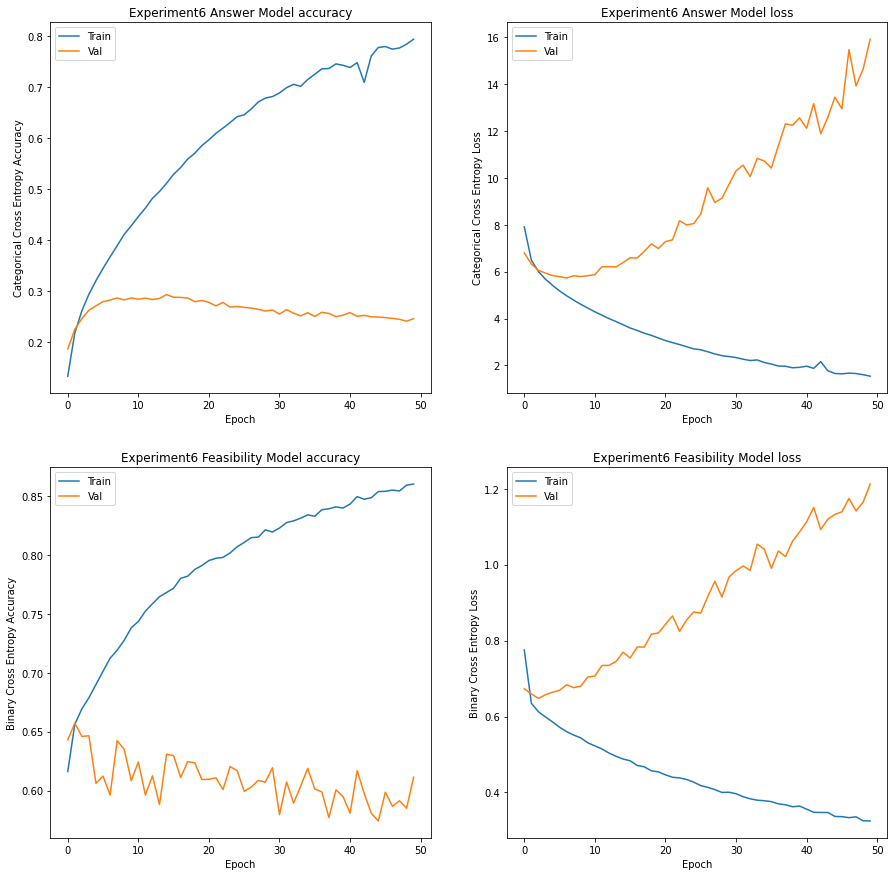

In [57]:
plot_experiments(6)

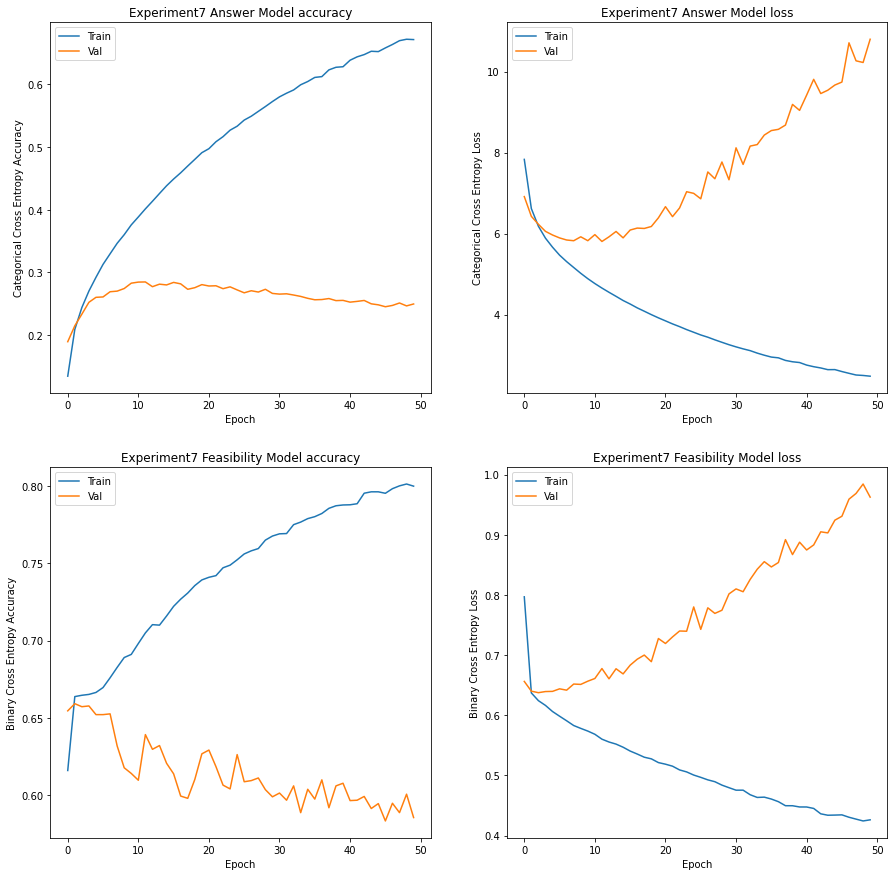

In [21]:
plot_experiments(7)

In [15]:
inference_feasibility_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feasibilityQuestion_Input (Inpu [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Identity (TensorFlo [(None, 128)]        0           feasibilityQuestion_Input[0][0]  
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 1, 128)]     0           tf_op_layer_Identity[0][0]       
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 128)]     0           feasibilityQuestion_Input[0][0]  
______________________________________________________________________________________________

In [16]:
inference_encoder_model.summary()

Model: "encoder_module"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context_Embedding (Embedding multiple                  8870200   
_________________________________________________________________
Context_Bid_Layer0 (Bidirect multiple                  102144    
_________________________________________________________________
Context_Bid_Layer1 (Bidirect multiple                  74496     
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
Question_Embedding (Embeddin multiple                  8870200   
_________________________________________________________________
Question_Bid_Layer0 (Bidirec multiple               

In [17]:
inference_answer_model.summary()

Model: "answer_module"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  16512     
_________________________________________________________________
dense_4 (Dense)              multiple                  16512     
Total params: 33,024
Trainable params: 33,024
Non-trainable params: 0
_________________________________________________________________
